In [1]:
import numpy as np
import lib.gradients as grad
import lib.data as data
import matplotlib.pyplot as plt
import lib.haar_wawelet_method.haar as haar
import lib.mesurements
%matplotlib inline

In [2]:
def my_exp(x,y,w1,w2):
    if (w1 == 0):
        return np.exp( w2*1j*y)
    return np.exp(w1*1j*x + w2*1j*y)

/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


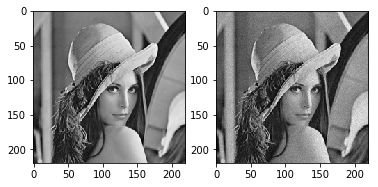

In [303]:
from scipy.misc import imread as imread
f, axarr = plt.subplots(1,2)
im = imread('220px-Lenna.png', 'graysckale', 'L')
axarr[0].imshow(im, cmap='gray')
axarr[1].imshow(data.get_Poisson_noise(im,1000), cmap='gray')


cпектр комлексной экспоненты с индексом i,j

#to do
исправить баг, с индексами i,j

функция compare вычисляет $e^{(1j*i*x, 1j*j*y)}$ на сеткe 2**M x 2**M.
затем находя градиенты , вычисляет значение функции.
noised определяет будет ли зашумлена функция.
возвращает отношение спектров исходного и восстановленного сигналов.
т.к. спектр комлескной экспоненты exp(1j*i*x, 1j*j*y) дельта функция, всё значение сосредоточено в 
окрестности точки i,j.
2 варианта , что возвращает функция :

1.отношение cпектров на [i,j] позиции


2.отнощение максимумов спекторов

ниже 2 варианта.

In [265]:
def compare(i,j,M, noised = False, photons = 1000):
    #x,y = data.get_plane(-np.pi, np.pi,-np.pi,np.pi,M)
    x,y = data.get_plane(-np.pi, np.pi,-np.pi,np.pi,M)
    im = my_exp(x,y,i,j)
    grad_X, grad_Y = grad.fried_model_gradient(im)
    X_H, Y_H = grad.Hudgin_gradien_model(im)
    if (noised):
        #как зашумлять комплексные числа?
        grad_X = data.get_wPoisson_noise(grad_X.real, photons) + 1j*data.get_Poisson_noise(grad_X.imag, photons)
        grad_Y = data.get_Poisson_noise(grad_Y.real, photons) + 1j*data.get_Poisson_noise(grad_Y.imag, photons)
        X_H = data.get_Poisson_noise(X_H.real, photons) + 1j*data.get_Poisson_noise(X_H.imag, photons)
        Y_H = data.get_Poisson_noise(Y_H.real, photons) + 1j*data.get_Poisson_noise(Y_H.imag, photons)
    LH, HL, HH = haar.analyze(grad_X, grad_Y, X_H, Y_H)
    res = haar.syntesis({0:np.array([[np.mean(im)*2**M]])}, LH, HL, HH,M)
    # print(np.abs(np.fft.fft2(im)[j,i]), np.abs(np.fft.fft2(res[M])[j,i]), np.abs(np.fft.fft2(im)).max())
    # return np.abs(np.fft.fft2(im)[j,i])/np.abs(np.fft.fft2(res[M])[j,i])
    return np.abs(np.fft.fft2(im)[j,i])/np.abs(np.fft.fft2(res[M])[j,i])

In [266]:
def calc_z (M, noised = False, photons = 1000):
    size = 2**M
    z = np.zeros(size**2).reshape(size,size)
    for i in range (size):
        for j in range(size):
            z[i,j] = compare(i,j,M, noised, photons)
    return z

In [299]:
def draw_plot(z):
    size = z.shape[0]
    x,y = np.meshgrid(range(0,size),range(0,size))
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.plot_wireframe(x * np.pi / (size - 1), y * np.pi / (size - 1), z)
    ax.set_zlim(0, 2)
    ax.set_xlim(0, np.pi)
    ax.set_ylim(0, np.pi)
    def format_func(value, tick_number):
        # find number of multiples of pi/2
        N = int(np.round(5 * value / np.pi))
        if N == 0:
            return "0"
        elif N == 1:
            return r"$\pi/5$"
        elif N == 5:
            return r"$\pi$"
        else :
            return r"${0}\pi/5$".format(N)
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoLocator, FuncFormatter
    majorLocator = MultipleLocator(np.pi / 5)
    majorFormatter = FuncFormatter(format_func)
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_formatter(majorFormatter)
    plt.show()

In [292]:
def draw_2d_plot(z) :
    y = np.zeros(z.shape[0])
    for i in range (0, z.shape[0]):
        y[i] = z[i,i]
    plt.plot(np.arange(0, z.shape[0]) * np.pi / (z.shape[0] - 1) , y)
    plt.xlim(0, np.pi)
    plt.ylim(0, 2)
    def format_func(value, tick_number):
        # find number of multiples of pi/2
        N = int(np.round(5 * value / np.pi))
        if N == 0:
            return "0"
        elif N == 1:
            return r"$\pi/5$"
        elif N == 5:
            return r"$\pi$"
        else :
            return r"${0}\pi/5$".format(N)
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoLocator, FuncFormatter
    majorLocator = MultipleLocator(np.pi / 5)
    majorFormatter = FuncFormatter(format_func)
    ax = plt.axes()
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    plt.show()

In [296]:
z = calc_z(4, True, 300)
#try catch везде

/home/satbek/Course-work-sem7/src/lib/data.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scale_factor = photons / noised_image.max()
/home/satbek/Course-work-sem7/src/lib/data.py:45: RuntimeWarning: invalid value encountered in multiply
  noised_image = noised_image * scale_factor
/home/satbek/Course-work-sem7/src/lib/data.py:46: RuntimeWarning: invalid value encountered in less
  noised_image = np.random.poisson(noised_image)
/home/satbek/Course-work-sem7/src/lib/data.py:46: RuntimeWarning: invalid value encountered in greater
  noised_image = np.random.poisson(noised_image)


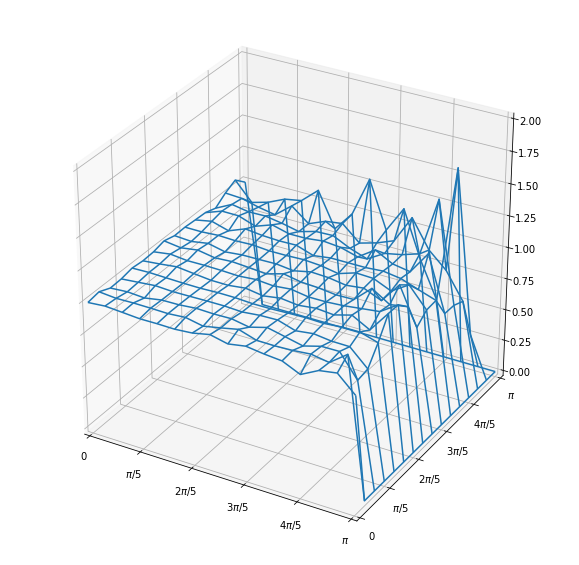

In [307]:
draw_plot(z)

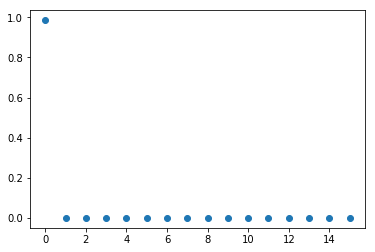

In [361]:
plt.plot(z[15], 'o')

/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


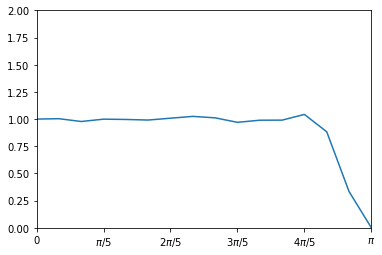

In [298]:
draw_2d_plot(z)

In [345]:
#Проверим какой график будет у частотной характеристики просто образа шума и изображения
def compare_without_haar(i,j,M, photons):
    #x,y = data.get_plane(-np.pi, np.pi,-np.pi,np.pi,M)
    x,y = data.get_plane(-np.pi, np.pi,-np.pi,np.pi,M)
    im = my_exp(x,y,i,j)
    res = data.get_Poisson_noise(im.real, photons) + 1j*data.get_Poisson_noise(im.imag, photons)
    # print(np.abs(np.fft.fft2(im)[j,i]), np.abs(np.fft.fft2(res[M])[j,i]), np.abs(np.fft.fft2(im)).max())
    # return np.abs(np.fft.fft2(im)[j,i])/np.abs(np.fft.fft2(res[M])[j,i])
    return np.abs(np.fft.fft2(im)[j,i])/np.abs(np.fft.fft2(res)[j,i])

In [348]:
def calc_z_without_haar (M, photons):
    size = 2**M
    z = np.zeros(size**2).reshape(size,size)
    for i in range (size):
        for j in range(size):
            z[i,j] = compare_without_haar(i,j,M, photons)
    return z

In [349]:
z_without_haar = calc_z_without_haar(4, 100)


/home/satbek/Course-work-sem7/src/lib/data.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  scale_factor = photons / noised_image.max()
/home/satbek/Course-work-sem7/src/lib/data.py:45: RuntimeWarning: invalid value encountered in multiply
  noised_image = noised_image * scale_factor
/home/satbek/Course-work-sem7/src/lib/data.py:46: RuntimeWarning: invalid value encountered in less
  noised_image = np.random.poisson(noised_image)
/home/satbek/Course-work-sem7/src/lib/data.py:46: RuntimeWarning: invalid value encountered in greater
  noised_image = np.random.poisson(noised_image)


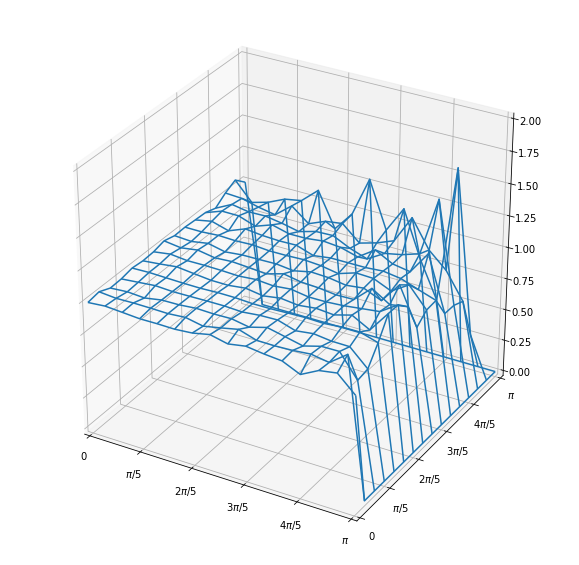

In [350]:
draw_plot(z)

/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


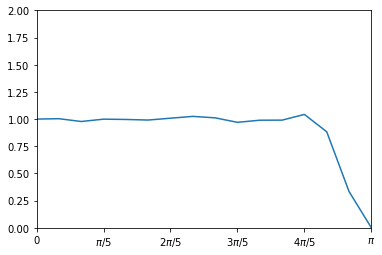

In [351]:
draw_2d_plot(z)

/home/satbek/python/anacondas/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'востановленное')

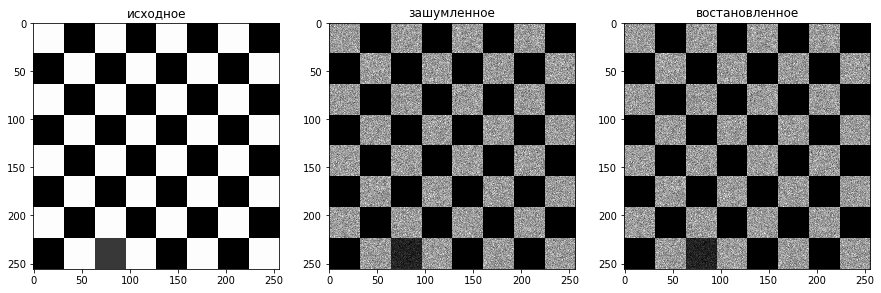

In [222]:
from scipy.misc import imread as imread
f, axarr = plt.subplots(1,3,figsize=(15,15))
im = imread('Lenna_square.jpeg', 'graysckale', 'L')
noised = data.get_Poisson_noise(im,40)

grad_X, grad_Y = grad.fried_model_gradient(noised)
X_H, Y_H = grad.Hudgin_gradien_model(noised)
LH, HL, HH = haar.analyze(grad_X, grad_Y, X_H, Y_H)
LL = {0 : np.array([[np.mean(im)]])}
LL = haar.syntesis(LL, LH, HL, HH, 8)

axarr[0].imshow(im, cmap='gray')
axarr[0].set_title('исходное')
axarr[1].imshow(noised, cmap='gray')
axarr[1].set_title('зашумленное')
axarr[2].imshow(LL[8], cmap='gray')
axarr[2].set_title('востановленное')

In [398]:
a = [1,2,3,4]
b = [1,2,3,4]
c = [[[y,x] for x in a] for y in b]

In [405]:
c[0][0]

[1, 1]